**Initial Model Test with pretrained Resnet models**

Change log level

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

Imports

In [ ]:
import matplotlib.pyplot as plotter_lib
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

Load data

In [16]:
test_data_directory = 'data/test'
train_data_directory = 'data/train'
valid_data_directory = 'data/valid'
batch_size = 32

def data_loader(directory, batch_size):
    ds = image_dataset_from_directory(
        directory = directory,
        seed = 1324,
        label_mode = 'categorical',
        image_size = (350, 350),
        batch_size = batch_size
    )  
    return ds

train_ds = data_loader(train_data_directory, batch_size)

test_ds = data_loader(test_data_directory, batch_size)

valid_ds = data_loader(valid_data_directory, batch_size)

Found 30249 files belonging to 2 classes.
Found 6299 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


In [17]:
class_names = train_ds.class_names
print(class_names)

['nowildfire', 'wildfire']


**Check for currupt JPEGS**
 - Train
    - Wildfire: 0
    - No Wildfire: 1 (-114.152378,51.027198)
 - Test
    - Wildfire: 1 (-73.15884,46.38819)
    - No Wildfire: 0
 - Valid
    - Wildfire: 0
    - No Wildfire: 0

In [5]:
#from os import listdir
#import cv2
#
#directory = 'data/valid/wildfire/'

#for filename in listdir(directory):
#  if filename.endswith(".jpg"):
#    print(directory+filename)
#    cv2.imread(directory+filename)

Display random examples of the dataset

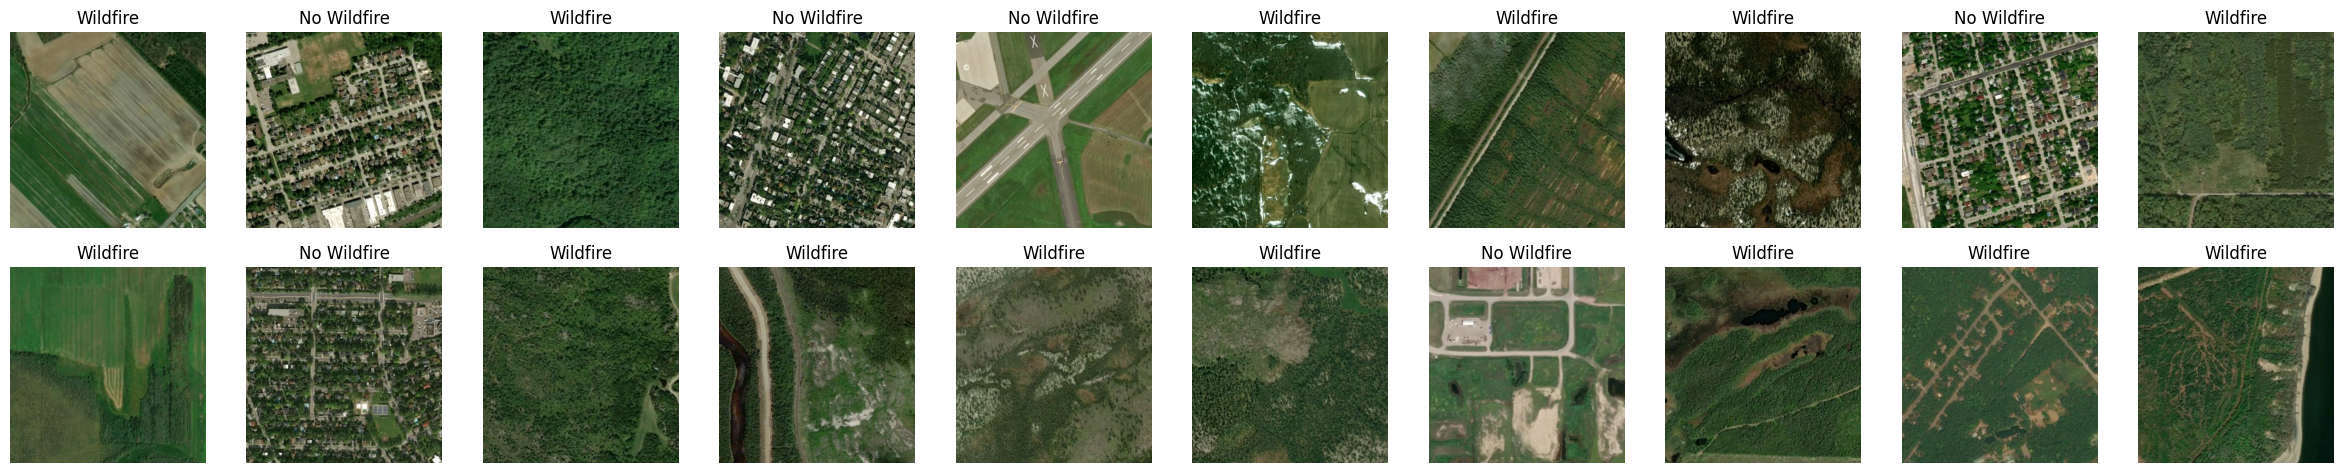

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize=(30,30))

for images, labels in train_ds.take(1):
    for var in range(20):

        ax = plt.subplot(10,10, var+1)

        #print(labels[var])
        
        if labels[var].numpy()[0]== 1.0:
            ax.set_title('No Wildfire')
        else:
            ax.set_title('Wildfire')
            
        plt.imshow(images[var].numpy().astype('uint8'))
        plt.axis('off')

Import pre-trained model

In [7]:
# initialize model
model = Sequential()

# import pretrained model
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(350,350,3),
    pooling='avg',
    weights='imagenet'
)

# exclude pretrained model weights from being recalculated
for layer in resnet_model.layers:
    layer.trainable = False

# add pretrained ResNet50 model to sequential model
model.add(resnet_model)

# add additional layers to model
model.add(Flatten())
model.add(Dense(512, tf.nn.relu))
model.add(Dense(2, tf.nn.softmax))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


Train model

- Experimented with:
    - Batch size (Tested 32, 64, 128, 256) => no noticeable impact on time and accuracy
    - Different model architecture (different layers); going for minimal setup; one hidden and one output layer (2 classes with softmax => 2 neurons)
        - without hidden dense layer higher loss, but similar accuracy
    - Experimented with amount of neurons in hidden dense layer (128,512) => no noticeable impact on time and accuracy
    - Compared training whole model (Resnet50 pre-trained weights too) to only training new layers:
        - longer training time per epoch and lower results
        - could get to base performance (only top layers trained, resnet layers excluded), but needs more epochs to get there => not worth it
    - Tested different size ResNet models: Model performance stays equal but takes longer -> not worth it
    - Experimented with different base models (DenseNet -> worse performance than ResNet)
    
=> Results with >0,98 accuracy should be sufficient

In [8]:
epochs = 10
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

Epoch 1/10
946/946 [==============================] - 57s 53ms/step - loss: 0.1182 - accuracy: 0.9595 - val_loss: 0.0619 - val_accuracy: 0.9787
Epoch 2/10
946/946 [==============================] - 49s 52ms/step - loss: 0.0636 - accuracy: 0.9761 - val_loss: 0.0524 - val_accuracy: 0.9837
Epoch 3/10
946/946 [==============================] - 49s 52ms/step - loss: 0.0505 - accuracy: 0.9809 - val_loss: 0.0642 - val_accuracy: 0.9814
Epoch 4/10
946/946 [==============================] - 50s 53ms/step - loss: 0.0409 - accuracy: 0.9857 - val_loss: 0.0543 - val_accuracy: 0.9863
Epoch 5/10
946/946 [==============================] - 52s 55ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.0603 - val_accuracy: 0.9835
Epoch 6/10
946/946 [==============================] - 50s 53ms/step - loss: 0.0235 - accuracy: 0.9913 - val_loss: 0.0651 - val_accuracy: 0.9837
Epoch 7/10
946/946 [==============================] - 52s 55ms/step - loss: 0.0215 - accuracy: 0.9924 - val_loss: 0.0586 - val_accuracy:

Save model

In [9]:
model.save('models/currentModel')

INFO:tensorflow:Assets written to: models/currentModel/assets


INFO:tensorflow:Assets written to: models/currentModel/assets


Plot results

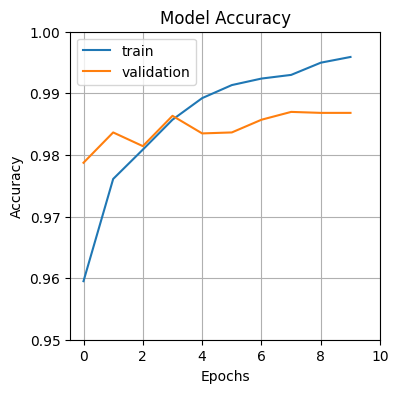

In [10]:
plt.figure(figsize=(4, 4))

epochs_range= range(epochs)

plt.plot( epochs_range, model.history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, model.history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.95,ymax=1, xmax=10)
plt.title('Model Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

In [11]:
score = model.evaluate(test_ds)

197/197 [==============================] - 10s 46ms/step - loss: 0.0508 - accuracy: 0.9884


In [12]:
# imports for requests and image preprocessing
import requests as rq
import tensorflow.keras.applications.resnet50 as resnet50
from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing import image


def evaluate_image(img, model):

    # preprocess image
    img.save('request.jpg')
    img_png = tf.keras.utils.load_img('request.jpg', target_size=(350, 350))
    img_array = tf.keras.utils.img_to_array(img_png)
    img_batch = tf.expand_dims(img_array, 0)

    # run prediction
    predictions = model.predict(img_batch)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "Class: {} ({:.2f}% confidence)"
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [19]:
# load last trained model for evaluation
#new_model = tf.keras.models.load_model('models/currentModel')

# load 'normal' trained model; resnet weights excluded from training
new_model = tf.keras.models.load_model('models/modelOnlyTopTrained')

# load 'full' trained model; resnet weights included in training
#new_model = tf.keras.models.load_model('models/model10EallParamsTrained')

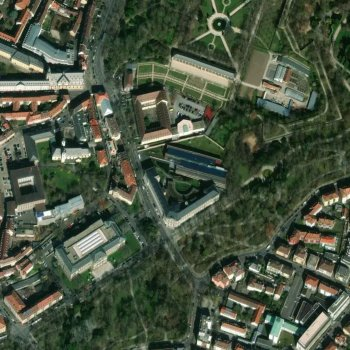

1/1 [==============================] - 0s 444ms/step
Class: nowildfire (73.11% confidence)


In [20]:
# get requested location from mapbox
# Image details: size 350x350px; zl 15; optional parameters &attribution=false &logo=false (remove watermark);

# picture of Würzburg
response = rq.get('https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/9.937,49.7892,15,0/350x350?access_token=pk.eyJ1IjoibTNuZGVsIiwiYSI6ImNsajV5a2syMjAxOW8zam9ibXp4dGFkNmQifQ.PA3LPn0Ihn_xJ-tOnEUsWg&attribution=false&logo=false')
img1= Image.open(BytesIO(response.content))
img1.show()

evaluate_image(img1, new_model)

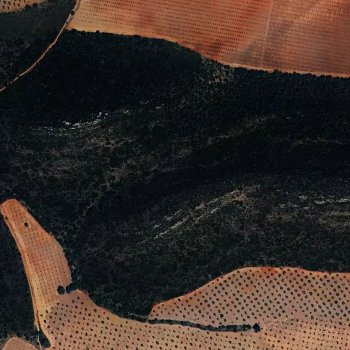

1/1 [==============================] - 0s 20ms/step
Class: wildfire (69.95% confidence)


In [21]:
# get requested location from mapbox
# Image details: size 350x350px; zl 15; optional parameters &attribution=false &logo=false (remove watermark);

# picture of equatorial spain
response2 = rq.get('https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/-3.523419,39.329238,15,0/350x350?access_token=pk.eyJ1IjoibTNuZGVsIiwiYSI6ImNsajV5a2syMjAxOW8zam9ibXp4dGFkNmQifQ.PA3LPn0Ihn_xJ-tOnEUsWg&attribution=false&logo=false')
img2 = Image.open(BytesIO(response2.content))
img2.show()

evaluate_image(img2, new_model)